## <a class="anchor" id="0"></a> <b>Оглавление<b/>

* [Задача 1](#1)
* [Задача 2](#2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
import shap
import itertools
import warnings
warnings.filterwarnings('ignore')

### <a class="anchor" id="1"></a> Задача 1

[Оглавление](#0)

Для сокращенных данных (train_cut_X и test_cut_X) реализовать метод отбора важности признаков по Шепли.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv')
X = df.drop(['target', 'index'], axis=1)
y = df[['target']]

In [3]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
train_cut_X = train_X[train_X.columns[:5]]
test_cut_X = test_X[train_X.columns[:5]]

reg = LinearRegression().fit(train_cut_X, train_y)

# вручную формула Шепли
def shapley_formula(calc_model, data_feat, example):
    features = data_feat.columns
    len_features = len(features)
    shapley = {feature: 0 for feature in features}
    
    for feature in features:
        other_features = [f for f in features if f != feature]
        for size in range(len(other_features) + 1):
            for subset in itertools.combinations(other_features, size):
                subset = list(subset)
                
                data_S = np.zeros((1, len_features))
                data_S[:, [list(features).index(s) for s in subset]] = example[subset].values
                pred_S = calc_model.predict(data_S)[0]
                
                data_S_U_i = data_S.copy()
                data_S_U_i[:, list(features).index(feature)] = example[feature]
                pred_S_U_i = calc_model.predict(data_S_U_i)[0]
                
                weight_feature = np.math.factorial(len(subset)) * np.math.factorial(len_features - len(subset) - 1) / np.math.factorial(len_features)
                shapley[feature] += weight_feature * (pred_S_U_i - pred_S)
    
    return shapley

example = test_cut_X.iloc[0]
data = shapley_formula(reg, test_cut_X, example)

df_shapley_formula = pd.DataFrame(list(data.items()), columns=['feature', 'value']) # признак и значение
df_shapley_formula['value'] = df_shapley_formula['value'].astype(float).abs()
df_shapley_formula = df_shapley_formula.sort_values(by='value', ascending=False)

df_shapley_formula.round(3)

,feature,value
0,back-suspension,108.887
2,charge-time,7.075
4,consumption-mixed,4.956
1,battery-capacity,2.462
3,compression,0.094


### <a class="anchor" id="2"></a> Задача 2

[Оглавление](#0)

Самостоятельно реализовать алгоритм отбора признаков на основе пермутационной важности. Построить гистограмму полученных значений.

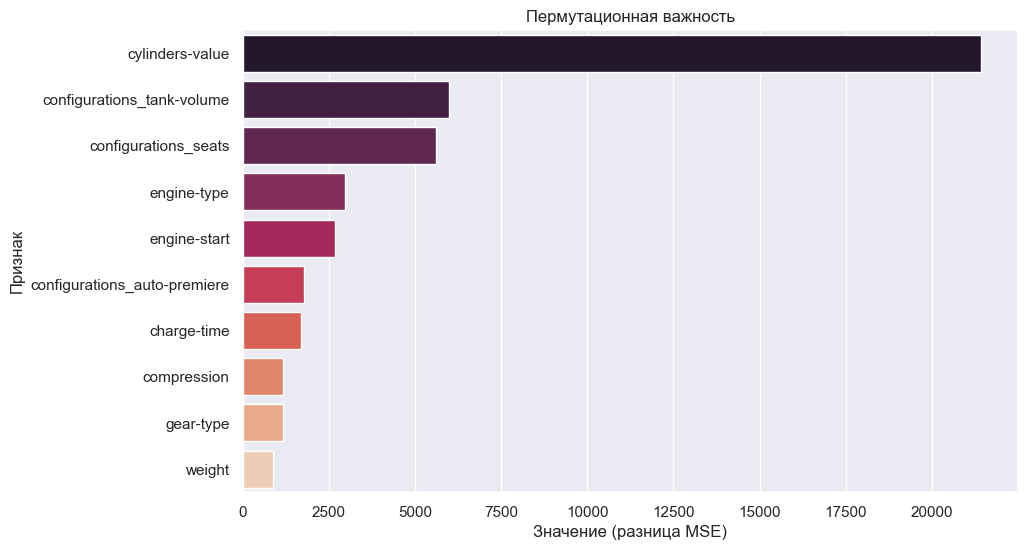

In [5]:
reg = LinearRegression().fit(train_X, train_y)
mse_0 = mean_squared_error(test_y, reg.predict(test_X))

# Функция пермутационной важности
def permutation_importance(model, X_test, y_test, metric=mean_squared_error, repeats=10, random_state=42):
    rng = np.random.default_rng(random_state)  # генератор случайных чисел
    importances = {feature: [] for feature in X_test.columns}

    for _ in range(repeats):
        for feature in X_test.columns:
            X_permuted = X_test.copy()
            X_permuted[feature] = rng.permutation(X_permuted[feature].values)  # перемешивание значений
            
            permuted_score = metric(y_test, model.predict(X_permuted))
            importances[feature].append(permuted_score - mse_0)

    return pd.Series({feature: np.mean(scores) for feature, scores in importances.items()})

perm_importance = permutation_importance(reg, test_X, test_y)

perm_importance_df = perm_importance.reset_index()
perm_importance_df.columns = ['feature', 'importance']
perm_importance_df = perm_importance_df.sort_values(by='importance', ascending=False)

# График - диаграмма
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=perm_importance_df.head(10), palette='rocket')
plt.title('Пермутационная важность')
plt.xlabel('Значение (разница MSE)')
plt.ylabel('Признак')
plt.show()